# Deep Neural Network for Image Classification

In [60]:
import numpy as np
import h5py
import time
import matplotlib.pyplot as plt
import scipy
import imageio
from skimage.transform import resize
from PIL import Image
from scipy import ndimage
from util import *
from dnn_util import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
def initialize_parameters(n_x, n_h, n_y):
    np.random.seed(1)
    
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1))
    
    assert(W1.shape == (n_h, n_x))
    assert(b1.shape == (n_h, 1))
    assert(W2.shape == (n_y, n_h))
    assert(b2.shape == (n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters    

In [18]:
parameters = initialize_parameters(3,2,1)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[ 0.01624345 -0.00611756 -0.00528172]
 [-0.01072969  0.00865408 -0.02301539]]
b1 = [[0.]
 [0.]]
W2 = [[ 0.01744812 -0.00761207]]
b2 = [[0.]]


In [19]:
def initialize_parameters_deep(layer_dims):

    np.random.seed(3)
    parameters = {}
    L = len(layer_dims)            # number of layers in the network

    for l in range(1, L):

        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))

        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))
    
    return parameters

In [20]:
parameters = initialize_parameters_deep([5,4,3])
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[ 0.01788628  0.0043651   0.00096497 -0.01863493 -0.00277388]
 [-0.00354759 -0.00082741 -0.00627001 -0.00043818 -0.00477218]
 [-0.01313865  0.00884622  0.00881318  0.01709573  0.00050034]
 [-0.00404677 -0.0054536  -0.01546477  0.00982367 -0.01101068]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]]
W2 = [[-0.01185047 -0.0020565   0.01486148  0.00236716]
 [-0.01023785 -0.00712993  0.00625245 -0.00160513]
 [-0.00768836 -0.00230031  0.00745056  0.01976111]]
b2 = [[0.]
 [0.]
 [0.]]


In [21]:
def sigmoid(Z):
    A = 1/(1+np.exp(-Z))
    cache = Z   
    return A, cache

In [22]:
def relu(Z):
    A = np.maximum(0,Z)    
    assert(A.shape == Z.shape)    
    cache = Z 
    return A, cache

In [23]:
def relu_backward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0  
    assert (dZ.shape == Z.shape)   
    return dZ

In [24]:
def sigmoid_backward(dA, cache):
    Z = cache 
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s) 
    assert (dZ.shape == Z.shape) 
    return dZ

In [25]:
def linear_forward(A, W, b):
    Z = np.dot(W, A) + b
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)   
    return Z, cache

In [26]:
A, W, b = linear_forward_test_case()
#print(b.shape)
Z, linear_cache = linear_forward(A, W, b)
print("Z = " + str(Z))

Z = [[ 3.26295337 -1.23429987]]


In [27]:
def linear_activation_forward(A_prev, W, b, activation):

    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
        
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)
    return A, cache

In [28]:
A_prev, W, b = linear_activation_forward_test_case()

A, linear_activation_cache = linear_activation_forward(A_prev, W, b, activation = "sigmoid")
print("With sigmoid: A = " + str(A))

A, linear_activation_cache = linear_activation_forward(A_prev, W, b, activation = "relu")
print("With ReLU: A = " + str(A))

With sigmoid: A = [[0.96890023 0.11013289]]
With ReLU: A = [[3.43896131 0.        ]]


In [29]:
def L_model_forward(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    
    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation= "relu")
        caches.append(cache)
    
    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation ="sigmoid")
    caches.append(cache)   
    assert(AL.shape == (1,X.shape[1]))          
    return AL, caches

In [30]:
X, parameters = L_model_forward_test_case_2hidden()
AL, caches = L_model_forward(X, parameters)
print("AL = " + str(AL))
print("Length of caches list = " + str(len(caches)))

AL = [[0.03921668 0.70498921 0.19734387 0.04728177]]
Length of caches list = 3


In [31]:
def compute_cost(AL, Y):
    m = Y.shape[1]
    cost = -1/m * np.sum( np.dot(Y, np.log(AL).T) +  np.dot(1-Y, np.log(1-AL).T))
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    assert(cost.shape == ())  
    return cost

In [32]:
Y, AL = compute_cost_test_case()

print("cost = " + str(compute_cost(AL, Y)))

cost = 0.2797765635793422


In [33]:
def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = 1/m * np.dot(dZ, A_prev.T)
    db = 1/m * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

In [34]:
# Set up some test inputs
dZ, linear_cache = linear_backward_test_case()

dA_prev, dW, db = linear_backward(dZ, linear_cache)
print ("dA_prev = "+ str(dA_prev))
print ("dW = " + str(dW))
print ("db = " + str(db))

dA_prev = [[-1.15171336  0.06718465 -0.3204696   2.09812712]
 [ 0.60345879 -3.72508701  5.81700741 -3.84326836]
 [-0.4319552  -1.30987417  1.72354705  0.05070578]
 [-0.38981415  0.60811244 -1.25938424  1.47191593]
 [-2.52214926  2.67882552 -0.67947465  1.48119548]]
dW = [[ 0.07313866 -0.0976715  -0.87585828  0.73763362  0.00785716]
 [ 0.85508818  0.37530413 -0.59912655  0.71278189 -0.58931808]
 [ 0.97913304 -0.24376494 -0.08839671  0.55151192 -0.10290907]]
db = [[-0.14713786]
 [-0.11313155]
 [-0.13209101]]


In [35]:
def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

In [36]:
dAL, linear_activation_cache = linear_activation_backward_test_case()

dA_prev, dW, db = linear_activation_backward(dAL, linear_activation_cache, activation = "sigmoid")
print ("sigmoid:")
print ("dA_prev = "+ str(dA_prev))
print ("dW = " + str(dW))
print ("db = " + str(db) + "\n")

dA_prev, dW, db = linear_activation_backward(dAL, linear_activation_cache, activation = "relu")
print ("relu:")
print ("dA_prev = "+ str(dA_prev))
print ("dW = " + str(dW))
print ("db = " + str(db))

sigmoid:
dA_prev = [[ 0.11017994  0.01105339]
 [ 0.09466817  0.00949723]
 [-0.05743092 -0.00576154]]
dW = [[ 0.10266786  0.09778551 -0.01968084]]
db = [[-0.05729622]]

relu:
dA_prev = [[ 0.44090989 -0.        ]
 [ 0.37883606 -0.        ]
 [-0.2298228   0.        ]]
dW = [[ 0.44513824  0.37371418 -0.10478989]]
db = [[-0.20837892]]


In [37]:
def L_model_backward(AL, Y, caches):

    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))

    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "dAL, current_cache". Outputs: "grads["dAL-1"], grads["dWL"], grads["dbL"]
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation="sigmoid")
    
    # Loop from l=L-2 to l=0
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        # Inputs: "grads["dA" + str(l + 1)], current_cache". Outputs: "grads["dA" + str(l)] , grads["dW" + str(l + 1)] , grads["db" + str(l + 1)] )
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l+1)], current_cache, activation="relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

In [38]:
AL, Y_assess, caches = L_model_backward_test_case()
grads = L_model_backward(AL, Y_assess, caches)
print_grads(grads)

dW1 = [[0.41010002 0.07807203 0.13798444 0.10502167]
 [0.         0.         0.         0.        ]
 [0.05283652 0.01005865 0.01777766 0.0135308 ]]
db1 = [[-0.22007063]
 [ 0.        ]
 [-0.02835349]]
dA1 = [[ 0.12913162 -0.44014127]
 [-0.14175655  0.48317296]
 [ 0.01663708 -0.05670698]]


In [39]:
def update_parameters(parameters, grads, learning_rate):  
    L = len(parameters) // 2 # number of layers in the neural network
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)]-learning_rate*grads["dW" + str(l + 1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)]-learning_rate*grads["db" + str(l + 1)]
    return parameters

In [40]:
parameters, grads = update_parameters_test_case()
parameters = update_parameters(parameters, grads, 0.1)

print ("W1 = "+ str(parameters["W1"]))
print ("b1 = "+ str(parameters["b1"]))
print ("W2 = "+ str(parameters["W2"]))
print ("b2 = "+ str(parameters["b2"]))

W1 = [[-0.59562069 -0.09991781 -2.14584584  1.82662008]
 [-1.76569676 -0.80627147  0.51115557 -1.18258802]
 [-1.0535704  -0.86128581  0.68284052  2.20374577]]
b1 = [[-0.04659241]
 [-1.28888275]
 [ 0.53405496]]
W2 = [[-0.55569196  0.0354055   1.32964895]]
b2 = [[-0.84610769]]


In [45]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

y = 1. It's a cat picture.


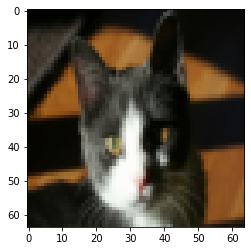

In [46]:
# Example of a picture
index = 19
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

In [47]:
# Explore your dataset 
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


In [48]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


In [49]:
### CONSTANTS DEFINING THE MODEL ####
n_x = 12288     # num_px * num_px * 3
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)

In [50]:

def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    np.random.seed(1)
    grads = {}
    costs = []                              # to keep track of the cost
    m = X.shape[1]                           # number of examples
    (n_x, n_h, n_y) = layers_dims
    
    # Initialize parameters dictionary, by calling one of the functions you'd previously implemented

    parameters = initialize_parameters(n_x, n_h, n_y)

    # Get W1, b1, W2 and b2 from the dictionary parameters.
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Loop (gradient descent)

    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> SIGMOID. Inputs: "X, W1, b1, W2, b2". Output: "A1, cache1, A2, cache2".

        A1, cache1 = linear_activation_forward(X, W1, b1, activation = "relu")
        A2, cache2 = linear_activation_forward(A1, W2, b2, activation= "sigmoid")

        # Compute cost

        cost = compute_cost(A2, Y)

        # Initializing backward propagation
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        
        # Backward propagation. Inputs: "dA2, cache2, cache1". Outputs: "dA1, dW2, db2; also dA0 (not used), dW1, db1".

        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, activation="sigmoid")
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, activation="relu")

        # Set grads['dWl'] to dW1, grads['db1'] to db1, grads['dW2'] to dW2, grads['db2'] to db2
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
        # Retrieve W1, b1, W2, b2 from parameters
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if print_cost and i % 100 == 0:
            costs.append(cost)
       
    # plot the cost

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 0.6930497356599888
Cost after iteration 100: 0.6464320953428849
Cost after iteration 200: 0.6325140647912677
Cost after iteration 300: 0.6015024920354665
Cost after iteration 400: 0.5601966311605747
Cost after iteration 500: 0.5158304772764729
Cost after iteration 600: 0.47549013139433255
Cost after iteration 700: 0.43391631512257495
Cost after iteration 800: 0.4007977536203886
Cost after iteration 900: 0.3580705011323798
Cost after iteration 1000: 0.3394281538366412
Cost after iteration 1100: 0.3052753636196264
Cost after iteration 1200: 0.2749137728213015
Cost after iteration 1300: 0.24681768210614846
Cost after iteration 1400: 0.19850735037466108
Cost after iteration 1500: 0.17448318112556654
Cost after iteration 1600: 0.17080762978096023
Cost after iteration 1700: 0.11306524562164728
Cost after iteration 1800: 0.09629426845937154
Cost after iteration 1900: 0.08342617959726861
Cost after iteration 2000: 0.07439078704319084
Cost after iteration 2100: 0.0663074

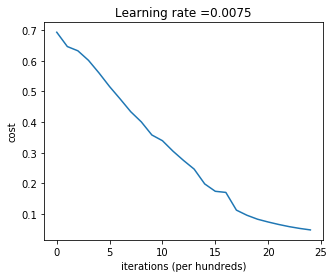

In [51]:
parameters = two_layer_model(train_x, train_y, layers_dims = (n_x, n_h, n_y), num_iterations = 2500, print_cost=True)

In [52]:
predictions_train = predict(train_x, train_y, parameters)

Accuracy: 0.9999999999999998


In [53]:
predictions_test = predict(test_x, test_y, parameters)

Accuracy: 0.72


In [54]:
### CONSTANTS ###
layers_dims = [12288, 20, 7, 5, 1] #  4-layer model

In [55]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):#lr was 0.009
    
    np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization. (≈ 1 line of code)
    parameters = initialize_parameters_deep(layers_dims)

    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_model_forward(X, parameters)

        cost = compute_cost(AL, Y)

        grads = L_model_backward(AL, Y, caches)

        parameters = update_parameters(parameters, grads, learning_rate)

        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 0.771749
Cost after iteration 100: 0.672053
Cost after iteration 200: 0.648263
Cost after iteration 300: 0.611507
Cost after iteration 400: 0.567047
Cost after iteration 500: 0.540138
Cost after iteration 600: 0.527930
Cost after iteration 700: 0.465477
Cost after iteration 800: 0.369126
Cost after iteration 900: 0.391747
Cost after iteration 1000: 0.315187
Cost after iteration 1100: 0.272700
Cost after iteration 1200: 0.237419
Cost after iteration 1300: 0.199601
Cost after iteration 1400: 0.189263
Cost after iteration 1500: 0.161189
Cost after iteration 1600: 0.148214
Cost after iteration 1700: 0.137775
Cost after iteration 1800: 0.129740
Cost after iteration 1900: 0.121225
Cost after iteration 2000: 0.113821
Cost after iteration 2100: 0.107839
Cost after iteration 2200: 0.102855
Cost after iteration 2300: 0.100897
Cost after iteration 2400: 0.092878


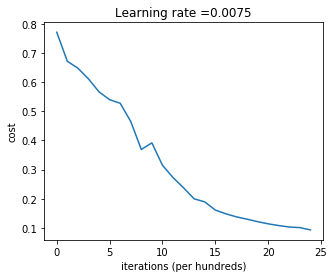

In [56]:
parameters = L_layer_model(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True)

In [57]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.9856459330143539


In [58]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.8


Accuracy: 0.0
y = 0.0, your L-layer model predicts a "non-cat" picture.


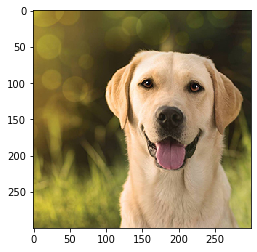

In [64]:
my_image = "dog.jpg" # change this to the name of your image file 
my_label_y = [1] # the true class of your image (1 -> cat, 0 -> non-cat)

fname = "images/" + my_image
image = np.array(imageio.imread(fname))
image = image/255
my_image = resize(image, output_shape=(num_px,num_px)).reshape((1, num_px*num_px*3)).T
my_predicted_image = predict(my_image, my_label_y, parameters)

plt.imshow(image)
print ("y = " + str(np.squeeze(my_predicted_image)) + ", your L-layer model predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")